# Projet MGL869 - Prédiction d'obésité

## Jeu de données

### Contexte

**Jeu de données : Estimation des niveaux d'obésité en fonction des habitudes alimentaires et de la condition physique**

Ce jeu de données comprend des données pour l'estimation des niveaux d'obésité chez des individus des pays du Mexique, du Pérou et de la Colombie, en se basant sur leurs habitudes alimentaires et leur condition physique.

Les données contiennent 17 attributs et 2111 enregistrements, ces enregistrements sont étiquetés avec la variable de classe NObesity (Niveau d'obésité), ce qui permet de classifier les données en utilisant les valeurs suivantes : Insuffisance pondérale, Poids normal, Surpoids Niveau I, Surpoids Niveau II, Obésité Type I, Obésité Type II et Obésité Type III. 77% des données ont été générées synthétiquement à l'aide de l'outil Weka et du filtre SMOTE, 23% des données ont été collectées directement auprès des utilisateurs via une plateforme web.

[Jeu de donnée disponible à cet addresse](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition) (2019)

### 1 - Importation des données

In [92]:
import numpy as np # algèbre linéaire
import pandas as pd # traitement des données, I/O de fichier CSV (par ex. pd.read_csv)
import seaborn as sns # bibliothèque de tracé qui utilise matplot
import matplotlib.pyplot as plt # pour tracer certains paramètres dans seaborn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

df = pd.read_csv("data/ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### 2 - Adaptation des types de données

On transforme les données pour que les types correspondent à ceux données sur le site ou est proposé le dataset.

In [93]:
df2 = df.copy();
# Object to category
df2[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]] = df2[["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]].astype("category")

# Object to binary
df2["family_history_with_overweight"] = df["family_history_with_overweight"].map({"yes": 1, "no": False})
df2["FAVC"] = df["FAVC"].map({"yes": 1, "no": False})
df2["SMOKE"] = df["SMOKE"].map({"yes": True, "no": False})
df2["SCC"] = df["SCC"].map({"yes": True, "no": False})

# Float to int
df2[["FCVC", "TUE"]] = df2[["FCVC", "TUE"]].astype("int")


df2.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,1,False,2,3.0,Sometimes,False,2.0,False,0.0,1,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,1,False,3,3.0,Sometimes,True,3.0,True,3.0,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,1,False,2,3.0,Sometimes,False,2.0,False,2.0,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,False,False,3,3.0,Sometimes,False,2.0,False,2.0,0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,False,False,2,1.0,Sometimes,False,2.0,False,0.0,0,Sometimes,Public_Transportation,Overweight_Level_II


### 3 - Intuitions vis à vis du jeu de données

In [94]:
df3 = df2.copy()

L'on remarque la présence des données "height" and "weight" dans notre dataset. En examinant l'article associé, l'on remarque que le niveau d'obésité est dérivé de l'IMC, un calcul ayant pour paramètre la taille et le poids. Si nous conservons ces données dans notre modèle, alors celui-ci ne présente plus d'intéret, car un simple calcul serait plus fiable.

Ainsi, une direction plus appropriée pour notre modèle serait de détermiiner si une personne est sujet à l'obésité à l'aide de caractéristiques autres que la taille et le poids, plus en rapport au mode de vie. Nous supprimons donc ces colonnes.

In [95]:
df3 = df3.drop(columns=["Height", "Weight"])

De plus, un certains nombre de propriétés sont déclarer comme des flotants. Or, quand on regarde les questions posées dans le papier pour l'obtention des informations, les réponses sont données sous forme de catégories avec une relation ordinal. Ce qui fait qu'avoir des nombres à virgules ne fait pas beacoup de sens dans certains cas.

Par exmple, la donnée CH2O représente la quantité d'eau bu par jour :
- 0 : Moins de 1L
- 1 : Entre 1 et 2L
- 2 : Plus de 2L

Dans ce contexte, une valeur de 0.5 ne fait pas de sens.

Pour remédier à ce problème, nous convertissons les données sujet à ce soucis en int.

In [96]:
columns = ["NCP", "CH2O", "FAF"]

for col in columns:
    #round to nearest whole number
    df3[col] = round(df3[col]).astype('int')

df3.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1,False,2,3,Sometimes,False,2,False,0,1,no,Public_Transportation,Normal_Weight
1,Female,21.0,1,False,3,3,Sometimes,True,3,True,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1,False,2,3,Sometimes,False,2,False,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,False,False,3,3,Sometimes,False,2,False,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,False,False,2,1,Sometimes,False,2,False,0,0,Sometimes,Public_Transportation,Overweight_Level_II


### 4 - Analyse des données


#### Infos et description

In [97]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2111 non-null   category
 1   Age                             2111 non-null   float64 
 2   family_history_with_overweight  2111 non-null   object  
 3   FAVC                            2111 non-null   object  
 4   FCVC                            2111 non-null   int64   
 5   NCP                             2111 non-null   int64   
 6   CAEC                            2111 non-null   category
 7   SMOKE                           2111 non-null   bool    
 8   CH2O                            2111 non-null   int64   
 9   SCC                             2111 non-null   bool    
 10  FAF                             2111 non-null   int64   
 11  TUE                             2111 non-null   int64   
 12  CALC                

On remarque qu'il n'y a pas de valeur NaN. Nous n'avons donc pas d'étape de supression des NaNs à effectuer.

In [98]:
df3.describe()

,Age,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,2.213169,2.687826,2.014685,1.006632,0.381336
std,6.345968,0.599397,0.809680,0.688616,0.895462,0.582536
min,14.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,2.000000,3.000000,2.000000,0.000000,0.000000
50%,22.777890,2.000000,3.000000,2.000000,1.000000,0.000000
75%,26.000000,3.000000,3.000000,2.000000,2.000000,1.000000
max,61.000000,3.000000,4.000000,3.000000,3.000000,2.000000


On remarque que la portée des données diffères beacoup entre l'âge et les valeurs ordinals. Nous aurons donc besoin d'une normalisation ou d'une standardisation.

In [99]:
df3.describe(include=["category"])

,Gender,CAEC,CALC,MTRANS,NObeyesdad
count,2111,2111,2111,2111,2111
unique,2,4,4,5,7
top,Male,Sometimes,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1765,1401,1580,351


La présence de données catégoriels nous indique la nécéssité de mettre en place du one hot encoding pour ces valeurs.

#### Donnée numérique floatants

3.9.0


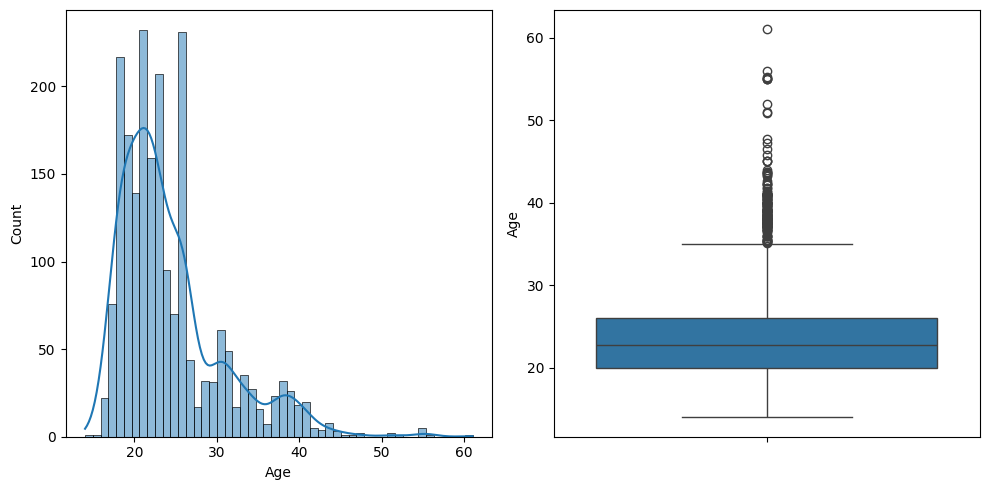

In [100]:
import matplotlib
from importlib.metadata import version
print(matplotlib.__version__)

fig, axes = plt.subplots(1,2, figsize=(10, 5))
axes = axes.flatten()

sns.histplot(df3["Age"], kde=True, ax=axes[0])
sns.boxplot(df3["Age"], ax=axes[1])
plt.tight_layout()
plt.show()

- **Age**
  - Type de valeur : Numérique continue
  - Distribution : Non normal
  - Problèmes : Données non normalisée
    - *Solution 1* : Appliquer une transformation pour normaliser la valeur
      - Exemple en dessous
    - *Solution 2* : Transformer la valeur en valeur categoriel
    - *Solution 3* : Garder les données telle quelles
  - Box plot : Indication de outliers
    - Cependant, données vérifiées car il s'agit d'un âge

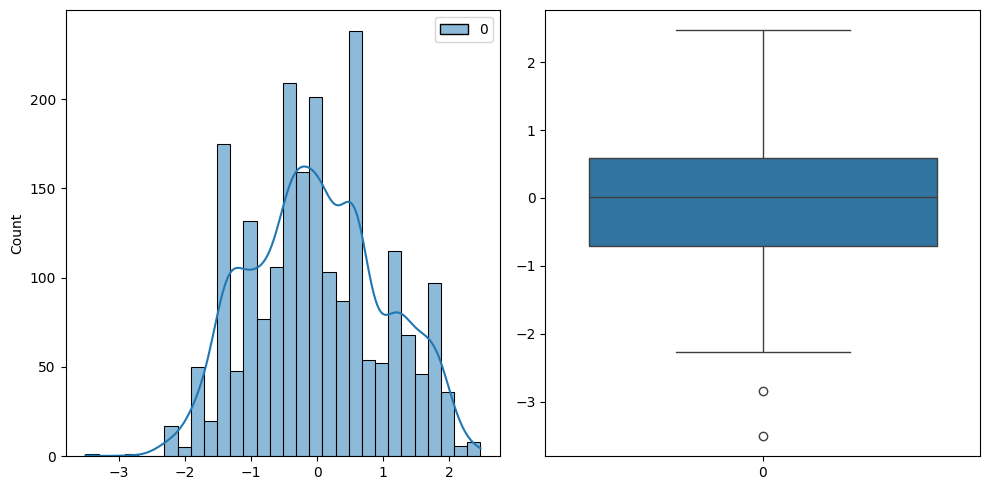

In [101]:
from sklearn.preprocessing import PowerTransformer

example = PowerTransformer().fit_transform(pd.DataFrame(df3["Age"]))

fig, axes = plt.subplots(1,2, figsize=(10, 5))
axes = axes.flatten()

sns.histplot(example, kde=True, ax=axes[0])
sns.boxplot(example, ax=axes[1])
plt.tight_layout()
plt.show()

#### Donnée numériques int

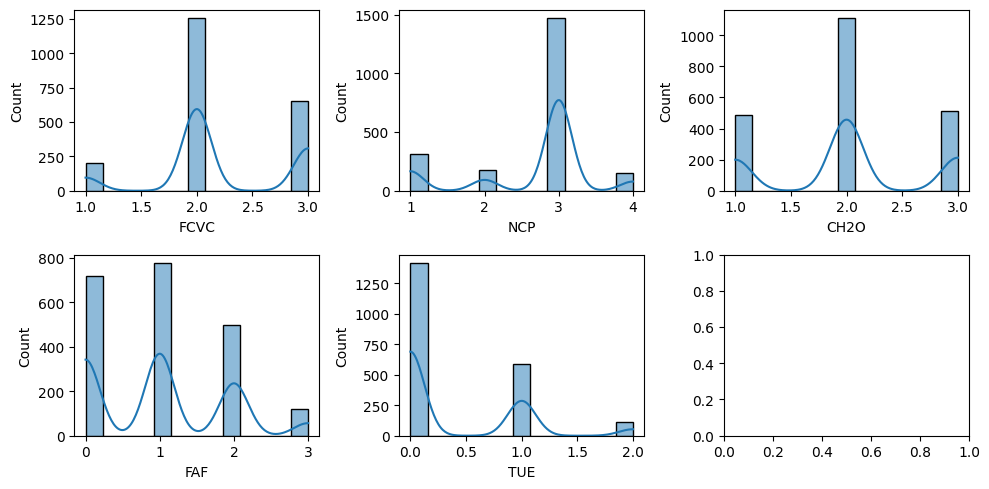

In [102]:
fig, axes = plt.subplots(2,3, figsize=(10, 5))
axes = axes.flatten()

for ax, col in zip(axes, ["FCVC", "NCP", "CH2O", "FAF", "TUE"]) :
    sns.histplot(df3[col], kde=True, ax=ax)

plt.tight_layout()
plt.show()

**Données**

- FCVC (Légumes dans les repas)
- NCP (Nombre de repas par jour)
- CH2O (Quantité d'eau bu par jour)
- FAF (Fréquence activité physique)
- TUE (Temps passé sur les écrans)

**Problèmes**  
Données non équilibrés

**Solutions**  
Downsampling et Upweighting. Il s'agit de deux techniques de construction de set de données permetant de mitiger les problèmes de données non équilibrés. Cependant, le déséquilibre n'etant pas extrème, nous n'implementerons pas cette solution.

**Remarques**  
De part leur nature, l'on pourrait penser les convertir en catégorie. Cependant, ces variables présentent des relations ordinales qu'il convient de conserver pour améliorer la justesse du modèle.

#### Données catégoriels et booléenes

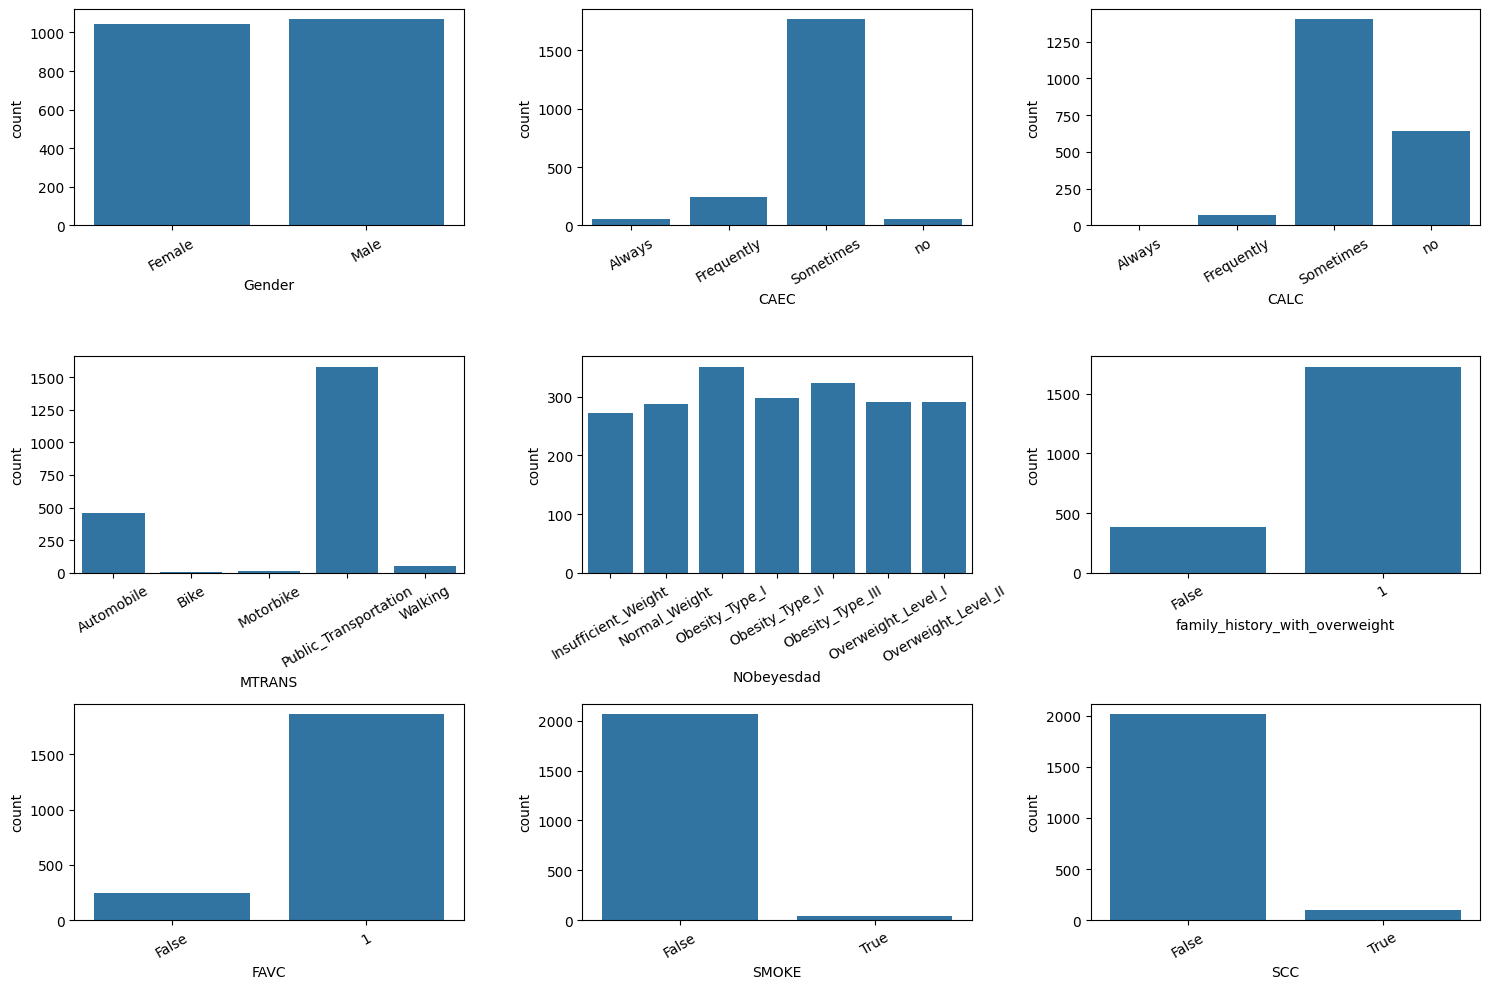

In [103]:
fig, axes = plt.subplots(3,3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, ["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]) :
    sns.countplot(x=df3[col], ax=ax)
    ax.tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()

**Données**

- Gender
- CAEC (Nourriture entre les repas)
- CALC (Fréquence alcool)
- MTRANS (Moyen de transport)
- Nobeyesdad (Catégorie d'obésité) (variable cible)
- family_history_with_overweight
- FAVC (Consomation fréquente de nourriture à haute calories)
- SMOKE
- SCC (Surveillance des calories)

**Problèmes**  
Données non équilibrés

**Solutions**  
Downsampling et Upweighting. Il s'agit de deux techniques de construction de set de données permetant de mitiger les problèmes de données non équilibrés. Cependant, le déséquilibre n'etant pas extrème, nous n'implementerons pas cette solution.

**Remarques**  
Certaines de ces catégories (CAEC, CALC, Nobeyesdad) ont des relation que l'on pourrait considérer ordinal. Conserver cette relation pourrait être intéréssant, nous pouvons donc appliquer un encoder oridinal sur ces valeurs.

#### Matrice de corrélation

In [104]:
corr_matrix = df3.select_dtypes(exclude=['category']).corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,Age,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE
Age,1.00,0.21,0.06,-0.02,-0.04,0.09,-0.02,-0.12,-0.13,-0.24
family_history_with_overweight,0.21,1.00,0.21,0.01,0.06,0.02,0.14,-0.19,-0.05,-0.10
FAVC,0.06,0.21,1.00,-0.07,-0.01,-0.05,0.01,-0.19,-0.10,-0.05
FCVC,-0.02,0.01,-0.07,1.00,0.07,0.03,0.12,0.07,-0.02,-0.15
NCP,-0.04,0.06,-0.01,0.07,1.00,0.01,0.06,-0.01,0.13,-0.00
SMOKE,0.09,0.02,-0.05,0.03,0.01,1.00,-0.04,0.05,0.01,0.06
CH2O,-0.02,0.14,0.01,0.12,0.06,-0.04,1.00,-0.00,0.12,-0.04
SCC,-0.12,-0.19,-0.19,0.07,-0.01,0.05,-0.00,1.00,0.07,0.03
FAF,-0.13,-0.05,-0.10,-0.02,0.13,0.01,0.12,0.07,1.00,0.08
TUE,-0.24,-0.10,-0.05,-0.15,-0.00,0.06,-0.04,0.03,0.08,1.00


L'on conclut qu'aucune valeurs ne sont manifestement corrélées entre elles.


### 5 - Nettoyage des données

À l'aide de nos explorations, nous avons déterminer que le nottoyage des données nécéssaire était :
- Suppresion des colonnes "Height" et "Weight"
- Transformation des colonnes restantes aux types spécifiées
- Conversions des données flotantes en int (sauf pour âge)


In [105]:
def import_clean_data(path):

    df = pd.read_csv(path, dtype={
      'Gender':'category',
      'CAEC':'category',
      'CALC':'category',
      'MTRANS':'category',
      'NObeyesdad':'category',
    })

    # No inplace possible
    df[["NCP", "CH2O", "FAF","FCVC", "TUE"]] = \
        df[["NCP", "CH2O", "FAF","FCVC", "TUE"]].apply(np.rint, axis=1).astype("int64")
    df[["family_history_with_overweight", "FAVC", "SMOKE", "SCC"]] = \
        df[["family_history_with_overweight", "FAVC", "SMOKE", "SCC"]].apply(lambda x: x.map({"yes": True, "no": False}), axis=0)
    df[["Gender"]] = \
        df[["Gender"]].apply(lambda x: x.map({"Male": 1, "Female": 0}), axis=0)

    return df

def drop_age_and_weight(df) :
    return df.drop(['Height', 'Weight'], axis=1)


df_clean = import_clean_data("data/ObesityDataSet_raw_and_data_sinthetic.csv")
df_clean = drop_age_and_weight(df_clean)
df_clean.head(10)


,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,True,False,2,3,Sometimes,False,2,False,0,1,no,Public_Transportation,Normal_Weight
1,0,21.0,True,False,3,3,Sometimes,True,3,True,3,0,Sometimes,Public_Transportation,Normal_Weight
2,1,23.0,True,False,2,3,Sometimes,False,2,False,2,1,Frequently,Public_Transportation,Normal_Weight
3,1,27.0,False,False,3,3,Sometimes,False,2,False,2,0,Frequently,Walking,Overweight_Level_I
4,1,22.0,False,False,2,1,Sometimes,False,2,False,0,0,Sometimes,Public_Transportation,Overweight_Level_II
5,1,29.0,False,True,2,3,Sometimes,False,2,False,0,0,Sometimes,Automobile,Normal_Weight
6,0,23.0,True,True,3,3,Sometimes,False,2,False,1,0,Sometimes,Motorbike,Normal_Weight
7,1,22.0,False,False,2,3,Sometimes,False,2,False,3,0,Sometimes,Public_Transportation,Normal_Weight
8,1,24.0,True,True,3,3,Sometimes,False,2,False,1,1,Frequently,Public_Transportation,Normal_Weight
9,1,22.0,True,True,2,3,Sometimes,False,2,False,1,1,no,Public_Transportation,Normal_Weight


### 6 - Validation des données

Pour la validation des données, nous avons tenté d'utiliser les mécanismes de validation inclus dans la bibliothèque Tensorflow. Cependant, du à des diffcultés d'import et à des icompatibilités de versions, nous avons choisi de réaliser notre propre classe de validation, nommée DataValidator.

Celle-ci permet de valider les données à l'aide d'un schéma sous la forme :
- Nom de la colonne
- Type attendu de la colonne
- Fonction lambda permettant d'ajouter des critères supplémentaires paramétrables

In [106]:
import warnings

class DataValidator:
    def __init__(self, schema : list[tuple[str, str, callable]]) -> None:
        self.schema = schema

    def isValid(self, df):
        # Check if the columns are the same
        df_cols = df.columns.tolist()
        df_cols.sort()
        schema_cols = [i for i, _, _ in self.schema]
        schema_cols.sort()

        if df_cols != schema_cols:
            warnings.warn("Data validation failed : Columns don't match")
            return False

        # Validate data
        for (col, datatype, validator) in self.schema:
            
            # Check for NaNs
            if df.isnull().sum().sum() > 0:
                warnings.warn("Data validation failed : NaN values found")
                return False

            # Validate type
            df_type = str(df[col].dtype)
            schema_type = datatype
            if df_type != schema_type:
                warnings.warn(f"Data validation failed : column '{col}' has type {df_type}, but should be {schema_type}")
                return False

            # Run validator
            for _, value in df[col].items():
                if validator and not validator(value):
                    warnings.warn(f"Data validation failed : '{col}' validator returned false on value {value}")
                    return False

        print("Data is validated !")
        return True

# Helper functions to generate lambda expressions

def lambda_range(min, max):
    return lambda x : x >= min and x <= max

def lambda_in(possible):
    return lambda x : x in possible


# Unit test

def testValidator():
    good_data = {
        'A': [1, 2, 3],
        'B': [4.0, 5.5, 6.2],
        'C': ['x', 'y', 'z'],
        'D': [True, True, False]
    }
    
    bad_data_nan = {
        'A': [1, 2, 3, 2],
        'B': [4.0, 5.5, 6.2, np.nan],
        'C': ['x', 'y', 'z', 'z'],
        'D': [True, True, False, False]
    }

    
    good_schema = [
        ("A", "int64", lambda_range(0, 4)),
        ("B", "float64", lambda x : x >= 4),
        ("C", "category", None),
        ("D", "bool", None)
    ]
    
    bad_schema_miss_col = [
        ("A", "int64", lambda_range(0, 4)),
        ("B", "float64", lambda x : x >= 4),
        ("C", "category", None),
    ]
    
    bad_schema_type = [
        ("A", "int64", lambda_range(0, 4)),
        ("B", "int64", lambda x : x >= 4),
        ("C", "category", None),
        ("D", "bool", None)
    ]
    
    bad_schema_validator = [
        ("A", "int64", lambda_range(0, 2)),
        ("B", "float64", lambda x : x >= 4),
        ("C", "category", None),
        ("D", "bool", None)
    ]
    
    # Working case
    df_test = pd.DataFrame(good_data)
    df_test['C'] = df_test['C'].astype("category")
    data_validator = DataValidator(good_schema)
    assert data_validator.isValid(df_test) == True
    
    # Schema error cases
    for i in [bad_schema_miss_col, bad_schema_type, bad_schema_validator]:
        data_validator = DataValidator(i)
        assert data_validator.isValid(df_test) == False
    
    # NaN case
    df_test = pd.DataFrame(bad_data_nan)
    df_test['C'] = df_test['C'].astype("category")
    data_validator = DataValidator(good_schema)
    assert data_validator.isValid(df_test) == False
    
    
testValidator()

Data is validated !


/tmp/ipykernel_9201/2476852676.py:15: UserWarning: Data validation failed : Columns don't match
  warnings.warn("Data validation failed : Columns don't match")
/tmp/ipykernel_9201/2476852676.py:30: UserWarning: Data validation failed : column 'B' has type float64, but should be int64
  warnings.warn(f"Data validation failed : column '{col}' has type {df_type}, but should be {schema_type}")
/tmp/ipykernel_9201/2476852676.py:36: UserWarning: Data validation failed : 'A' validator returned false on value 3
  warnings.warn(f"Data validation failed : '{col}' validator returned false on value {value}")
/tmp/ipykernel_9201/2476852676.py:23: UserWarning: Data validation failed : NaN values found
  warnings.warn("Data validation failed : NaN values found")


On réalise ensuite un schéma pour notre data frame nettoyé.

In [107]:
df_schema = [
    ("Age", "float64", lambda_range(14,99)),
    ("family_history_with_overweight", "bool", None),
    ("FAVC", "bool", None),
    ("SMOKE", "bool", None),
    ("SCC", "bool", None),
    ("FCVC", "int64", lambda_in ([1, 2, 3])),
    ("NCP", "int64", lambda_in ([1, 2, 3, 4])),
    ("CH2O", "int64", lambda_in ([1, 2, 3])),
    ("FAF", "int64", lambda_in ([0, 1, 2, 3])),
    ("TUE", "int64", lambda_in ([0, 1, 2])),
    ("Gender", "category", lambda_in ([0,1])),
    ("CAEC", "category", lambda_in (["Always", "Frequently", "Sometimes", "no"])),
    ("CALC", "category", lambda_in (["Always", "Frequently", "Sometimes", "no"])),
    ("MTRANS", "category", lambda_in (["Automobile", "Bike", "Motorbike",
                                            "Public_Transportation", "Walking"])),
    ("NObeyesdad", "category", lambda_in ([
        "Insufficient_Weight", "Normal_Weight",
        "Obesity_Type_I", "Obesity_Type_II",
        "Obesity_Type_III", "Overweight_Level_I",
        "Overweight_Level_II"]))
]

data_validator = DataValidator(df_schema)

data_validator.isValid(drop_age_and_weight(import_clean_data("data/ObesityDataSet_raw_and_data_sinthetic.csv")))

Data is validated !


True

### 7 - Pipeline de traitement

Avec notre analyse, nous pouvons imaginer la pipelines suivantes:
- Pour la colonne age, on peut:
  - Appliquer le Power Encoding sur Age pour rendre normale la distribution
  - Catégoriser la variable
- Appliquer le Ordinal Encoding sur CAEC et CALC
- Appliquer le OneHot Encoding sur Gender, MTRANS, familiy_history_with_overweight, FAVC
- Standardiser l'ensemble des données

In [108]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer, OneHotEncoder, StandardScaler, Normalizer, KBinsDiscretizer

# Dataset import
df = import_clean_data("data/ObesityDataSet_raw_and_data_sinthetic.csv")
df = drop_age_and_weight(df)

# Data valdation
data_validator.isValid(df)


# Dataset split
Y = df['NObeyesdad']
X = df.drop(['NObeyesdad'], axis=1) # On enlève le target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Data is validated !


In [109]:
# Power Transformer
power_features = ["Age"]

# Standardization
numeric_features = X.select_dtypes(include=["float64", "int64"]).drop(["Age"], axis=1).columns

# One hot encoding
categorical_features_onehot = ["Gender", "MTRANS",
                               "family_history_with_overweight", "FAVC",
                               "SMOKE", "SCC"]

# Ordinal encoding
categorical_features_ordinal = ["CAEC", "CALC"]


# On créer la pipeline de preprocessing
preprocessor = ColumnTransformer([
    # ("power", KBinsDiscretizer(encode='ordinal', strategy='uniform'), power_features), # Version catégorisation
    ("power", PowerTransformer(), power_features), # Version Normalisation
    ("scaler", StandardScaler(), numeric_features),
    ("oneHotEncoder", OneHotEncoder(handle_unknown="ignore"), categorical_features_onehot),
    ("ordinalEncoder", OrdinalEncoder(categories=[["no", "Sometimes", "Frequently", "Always"],["no", "Sometimes", "Frequently", "Always"]]), categorical_features_ordinal),
])

with pd.option_context('display.max_columns', None):
    display(X.head(5))
    display(pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out()).head(5))

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0,21.0,True,False,2,3,Sometimes,False,2,False,0,1,no,Public_Transportation
1,0,21.0,True,False,3,3,Sometimes,True,3,True,3,0,Sometimes,Public_Transportation
2,1,23.0,True,False,2,3,Sometimes,False,2,False,2,1,Frequently,Public_Transportation
3,1,27.0,False,False,3,3,Sometimes,False,2,False,2,0,Frequently,Walking
4,1,22.0,False,False,2,1,Sometimes,False,2,False,0,0,Sometimes,Public_Transportation


,power__Age,scaler__FCVC,scaler__NCP,scaler__CH2O,scaler__FAF,scaler__TUE,oneHotEncoder__Gender_0,oneHotEncoder__Gender_1,oneHotEncoder__MTRANS_Automobile,oneHotEncoder__MTRANS_Bike,oneHotEncoder__MTRANS_Motorbike,oneHotEncoder__MTRANS_Public_Transportation,oneHotEncoder__MTRANS_Walking,oneHotEncoder__family_history_with_overweight_False,oneHotEncoder__family_history_with_overweight_True,oneHotEncoder__FAVC_False,oneHotEncoder__FAVC_True,oneHotEncoder__SMOKE_False,oneHotEncoder__SMOKE_True,oneHotEncoder__SCC_False,oneHotEncoder__SCC_True,ordinalEncoder__CAEC,ordinalEncoder__CALC
0,-0.414452,-0.725454,0.385644,-0.021330,-1.124415,0.497717,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.414452,0.987559,0.385644,1.431202,2.226606,-0.986295,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,0.055560,-0.725454,0.385644,-0.021330,1.109599,0.497717,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
3,0.739738,0.987559,0.385644,-0.021330,1.109599,-0.986295,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
4,-0.165942,-0.725454,-2.085053,-0.021330,-1.124415,-0.986295,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


### 8 - Mise en oeuvre des modèles

Les modèles que nous avons choisis sont : 
- RandomForest
- DecisionTreeClassifier
- LinearSVC

Pour les choisir, nous avons utiliser l'aide mémoire de sklearn :

![sckit_map](figures/map.png)

Les méthodes que nous avons choisis d'utiliser pour l'optimisation des hyperparamètres sont :
- RandomSearch
- GridSearch

Nous avons de plus utiliser la cross-validation sur le DecisionTree

#### **RandomForest**

In [110]:
# On rajoute le model
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rforest", RandomForestClassifier())
    ]
)

param_grid = {
    'rforest__n_estimators': [300, 500, 700],
    'rforest__max_depth': [10, 15, 20],
    'rforest__min_samples_split': [2, 5, 8],
    'rforest__bootstrap': [True, False],
}

**Optimisation et mesures avec GridSearch**

In [111]:
# 1ms
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring="f1_macro")
grid_search.fit(X_train, Y_train)
display(f'Params: {grid_search.best_params_} \n F1 Score: {grid_search.best_score_}')


"Params: {'rforest__bootstrap': False, 'rforest__max_depth': 20, 'rforest__min_samples_split': 5, 'rforest__n_estimators': 700} \n F1 Score: 0.787991824253138"

In [112]:
from sklearn.metrics import recall_score

# 0s
Y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")
recall_val = recall_score(Y_test, Y_pred, average='macro')
print(f"Recall : {recall_val}")

Accuracy: 0.8085106382978723
Recall : 0.8045631811379469


**Optimisation et mesures avec RandomSearch**

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_distribs = {
    "rforest__n_estimators": sp_randint(100, 700),
    "rforest__max_depth": sp_randint(10, 100),
    "rforest__min_samples_split": sp_randint(2, 20),
    "rforest__min_samples_leaf": sp_randint(1, 10),
    "rforest__bootstrap": [True, False]
}

# Effectuer la recherche aléatoire
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distribs,
    scoring="f1_macro",
    cv=3,
    n_iter=100,
    n_jobs=-1
)

# Entraîner le pipeline sur les données d'entraînement
# 1ms
random_search.fit(X_train, Y_train)
display(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_}')

"Params: {'rforest__bootstrap': False, 'rforest__max_depth': 20, 'rforest__min_samples_split': 5, 'rforest__n_estimators': 700} \nScore: 0.787991824253138"

In [114]:
# 0s
Y_pred = random_search.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print(f'Accuracy: {accuracy}')
# Calculer le rappel
recall_val = recall_score(Y_test, Y_pred, average='macro')
print(f"Recall : {recall_val}")
bestRforest = grid_search.best_estimator_

Accuracy: 0.8014184397163121
Recall : 0.7974325825136249


#### **DecisionTreeClassifier**

In [115]:
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("dTree", DecisionTreeClassifier())
    ]
)


**Entraînement**


In [116]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power', PowerTransformer(),
                                                  ['Age']),
                                                 ('scaler', StandardScaler(),
                                                  Index(['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'MTRANS',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC']),
                                                 ('ordinalEncoder',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always'],
                                                                             ['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always']]),
                                                  ['CAEC', 'CALC'])])),
                ('dTree', DecisionTreeClassifier())])

**Résultat de la Cross-validation**

In [117]:
from sklearn.model_selection import cross_val_score
cv_dt = cross_val_score(pipeline, X_train, Y_train, cv=10)

print(cv_dt)
print(cv_dt.mean())

[0.67455621 0.75739645 0.72781065 0.74556213 0.71597633 0.78106509
 0.74556213 0.72189349 0.73809524 0.76190476]
0.73698224852071


**Mesures sans optimisations**

In [118]:
from sklearn.metrics import recall_score, f1_score
pipeline.fit(X_train, Y_train)

# 0s
y_pred_val = pipeline.predict(X_test)

acc_val = accuracy_score(Y_test, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val}")

# Calculer le rappel
recall_val = recall_score(Y_test, y_pred_val, average='macro')
print(f"Rappel sur les données de validation : {recall_val}")

# Calculer le F1 score
f1_val = f1_score(Y_test, y_pred_val, average='macro')
print(f"F1 score sur les données de validation : {f1_val}")

Accuracy sur les données de validation : 0.7115839243498818
Rappel sur les données de validation : 0.7079164447502284
F1 score sur les données de validation : 0.7070275658375051


**Optimisation et mesures avec GridSearch**

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

param_grid = {
    "dTree__criterion": ["gini", "entropy", 'log_loss'],
    "dTree__max_depth": [None, 10, 20, 30],
    "dTree__min_samples_split": [2, 5, 10],
    "dTree__min_samples_leaf": [1, 2, 4]
}

# 3s
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, Y_train)
display(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_}')

"Params: {'dTree__criterion': 'log_loss', 'dTree__max_depth': 30, 'dTree__min_samples_leaf': 1, 'dTree__min_samples_split': 2} \nScore: 0.7093042226530848"

In [120]:
# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de validation
# 0s
Y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')
recall_val = recall_score(Y_test, Y_pred, average='macro')
print(f"Recall : {recall_val}")

Accuracy: 0.7021276595744681
Recall : 0.6935312420510259


**Optimisation et mesures avec RandomSearch**

In [121]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Définir le dictionnaire de grille
param_distribs = {
    "dTree__criterion": ["gini", "entropy"],
    "dTree__max_depth": sp_randint(10, 100),
    "dTree__min_samples_split": sp_randint(2, 20),
    "dTree__min_samples_leaf": sp_randint(1, 10)
}

# Effectuer la recherche aléatoire
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distribs,
    scoring="f1_macro",
    cv=3,
    n_iter=100,
    n_jobs=-1,
)

# Entraîner le pipeline sur les données d'entraînement
# 3s
random_search.fit(X_train, Y_train)
display(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_}')

"Params: {'dTree__criterion': 'log_loss', 'dTree__max_depth': 30, 'dTree__min_samples_leaf': 1, 'dTree__min_samples_split': 2} \nScore: 0.7093042226530848"

In [122]:
# 0s
Y_pred = random_search.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')
# Calculer le rappel
recall_val = recall_score(Y_test, Y_pred, average='macro')
print(f"Recall : {recall_val}")
bestDTree = grid_search.best_estimator_

Accuracy: 0.7044917257683215
Recall : 0.6949251275764862


#### **SVC Linéaire**

In [123]:
from sklearn.svm import LinearSVC


pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("svcl", LinearSVC())
        # ("voting", model)
    ]
)

# Entraîner le modèle LinearSVC sur les données d'entraînement
pipeline.fit(X_train, Y_train)

# Évaluer le modèle LinearSVC sur les données de validation
# 0s
y_pred_val = pipeline.predict(X_test)
acc_val = accuracy_score(Y_test, y_pred_val)
print(f"Accuracy sur les données de validation : {acc_val}")


Accuracy sur les données de validation : 0.5910165484633569


**Optimisation et mesures avec GridSearch**

In [124]:
param_grid = {
    "svcl__C": [0.01, 0.1, 1, 10, 100],
    "svcl__penalty": ["l1", "l2"],
    "svcl__max_iter":[1000, 3000]
}

# 5s
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, Y_train)
display(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_}')

/home/paulc/ets_t_3/ia/mgl869/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/paulc/ets_t_3/ia/mgl869/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/paulc/ets_t_3/ia/mgl869/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/paulc/ets_t_3/ia/mgl869/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/paulc/ets_t_3/ia/mgl869/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/paulc/ets_t_3/ia/mgl869/

"Params: {'svcl__C': 1, 'svcl__max_iter': 1000, 'svcl__penalty': 'l1'} \nScore: 0.5318360944187676"

In [125]:
# Évaluer le modèle DecisionTreeClassifier optimisé sur les données de validation
# 0s
Y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')
# Calculer le rappel
recall_val = recall_score(Y_test, Y_pred, average='macro')
print(f"Rappel sur les données de validation : {recall_val}")
bestSvcl = grid_search.best_estimator_

Accuracy: 0.5862884160756501
Rappel sur les données de validation : 0.5788411479933806


On ne test pas la recherche aléatoire sur ce modèle puisque de toute façons les résultats sont beaucoup moins bon que pour les 2 précédents

### 9 - Comparaison des modèles

In [126]:
from sklearn.metrics import f1_score, precision_score


for model, name in [(bestRforest, "RandomForest"), (bestDTree, "DecisionTree"), (bestSvcl, "LinearSVC")]:
    # 0s
    Y_pred = model.predict(X_test)
    accuracy_val = accuracy_score(Y_test, Y_pred)
    recall_val = recall_score(Y_test, Y_pred, average='macro')
    precision_val = precision_score(Y_test, Y_pred, average='macro')
    f1_val = f1_score(Y_test, Y_pred, average='macro')

    display(f'{name} Accuracy: {accuracy_val}, Rappel : {recall_val}, Precision : {precision_val}, f1 : {f1_val}')

'RandomForest Accuracy: 0.8085106382978723, Rappel : 0.8045631811379469, Precision : 0.8022895025335102, f1 : 0.8022715524624952'

'DecisionTree Accuracy: 0.7021276595744681, Rappel : 0.6935312420510259, Precision : 0.6987159629250694, f1 : 0.6954152652322393'

'LinearSVC Accuracy: 0.5862884160756501, Rappel : 0.5788411479933806, Precision : 0.5675396702114457, f1 : 0.5546834488655459'

On observe que parmis nos modèles le RandomForest est le meilleur. Cependant, le DecisionTree a un temps d'entrainement beaucoup plus court ce qui implique aussi de plus faible émission de co2 dans notre cas.

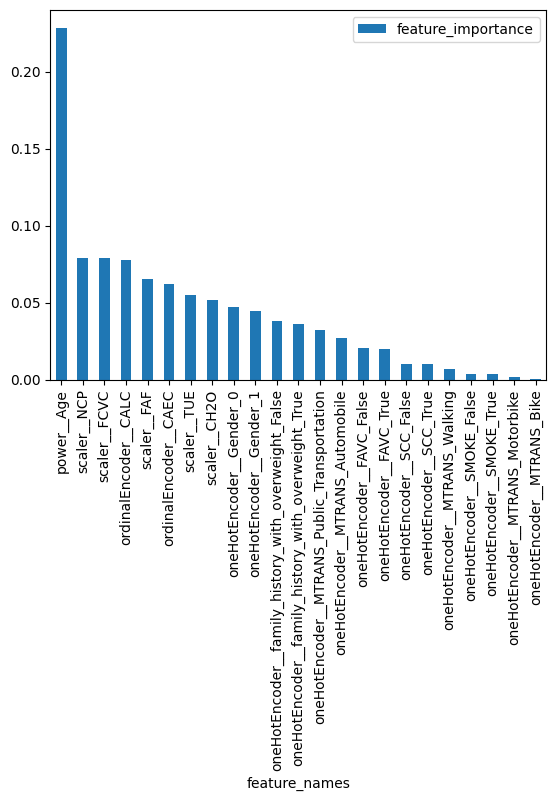

In [127]:
model = bestRforest.named_steps.popitem()[1]
names = bestRforest[:-1].get_feature_names_out()
feature_importance_df = pd.DataFrame \
    .from_dict({'feature_importance': model.feature_importances_, 'feature_names': names}) \
    .set_index('feature_names').sort_values('feature_importance', ascending = False).plot.bar()

Sauvegarde des modèles pour un usage dans l'appli web.

In [128]:
import joblib

for estimator, name in [(bestRforest, "RandomForest"), (bestDTree, "DecisionTree"), (bestSvcl, "LinearSVC")]:
    # We store the fit function's input's metadata for easier reshaping
    joblib.dump({
        'estimator': estimator,
        'input_columns': X.columns,
        'input_dtypes': X.dtypes,
    }, f"models/{name}.joblib", compress=3)

### 10 - Essai avec Height et Weight

Comme expliqué précédemment, l'inclusion de la taille et du poids ne fait pas de sens dans notre cas. Cependant, nous avons essayé de les inclures pour voir l'amélioration qui pourrait ếtre produite.

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0,21.0,1.62,64.0,True,False,2,3,Sometimes,False,2,False,0,1,no,Public_Transportation
1,0,21.0,1.52,56.0,True,False,3,3,Sometimes,True,3,True,3,0,Sometimes,Public_Transportation
2,1,23.0,1.80,77.0,True,False,2,3,Sometimes,False,2,False,2,1,Frequently,Public_Transportation
3,1,27.0,1.80,87.0,False,False,3,3,Sometimes,False,2,False,2,0,Frequently,Walking
4,1,22.0,1.78,89.8,False,False,2,1,Sometimes,False,2,False,0,0,Sometimes,Public_Transportation


,power__Age,scaler__Height,scaler__Weight,scaler__FCVC,scaler__NCP,scaler__CH2O,scaler__FAF,scaler__TUE,oneHotEncoder__Gender_0,oneHotEncoder__Gender_1,oneHotEncoder__MTRANS_Automobile,oneHotEncoder__MTRANS_Bike,oneHotEncoder__MTRANS_Motorbike,oneHotEncoder__MTRANS_Public_Transportation,oneHotEncoder__MTRANS_Walking,oneHotEncoder__family_history_with_overweight_False,oneHotEncoder__family_history_with_overweight_True,oneHotEncoder__FAVC_False,oneHotEncoder__FAVC_True,oneHotEncoder__SMOKE_False,oneHotEncoder__SMOKE_True,oneHotEncoder__SCC_False,oneHotEncoder__SCC_True,ordinalEncoder__CAEC,ordinalEncoder__CALC
0,-0.414452,-0.875589,-0.862558,-0.725454,0.385644,-0.021330,-1.124415,0.497717,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.414452,-1.947599,-1.168077,0.987559,0.385644,1.431202,2.226606,-0.986295,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,0.055560,1.054029,-0.366090,-0.725454,0.385644,-0.021330,1.109599,0.497717,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
3,0.739738,1.054029,0.015808,0.987559,0.385644,-0.021330,1.109599,-0.986295,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
4,-0.165942,0.839627,0.122740,-0.725454,-2.085053,-0.021330,-1.124415,-0.986295,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


"Params: {'dTree__criterion': 'log_loss', 'dTree__max_depth': 20, 'dTree__min_samples_leaf': 1, 'dTree__min_samples_split': 2} \nScore: 0.9389671638949878"

'Accuracy: 0.9621749408983451, Rappel : 0.9625460611214623, Precision : 0.9621782117022997, f1 : 0.9619771055260365'

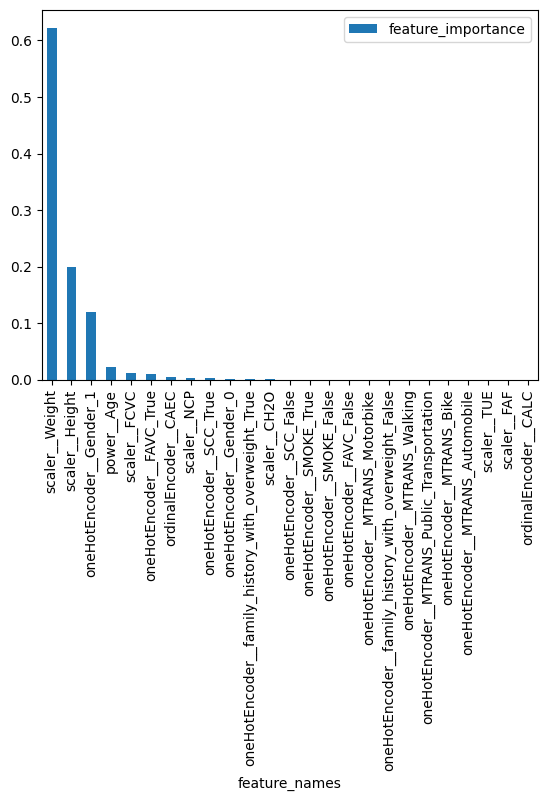

In [129]:
df = import_clean_data("data/ObesityDataSet_raw_and_data_sinthetic.csv")
# df = drop_age_and_weight(df) (On garde height et weight)

# Data valdation
# data_validator.validate(df)

# Dataset split
Y = df['NObeyesdad']
X = df.drop(['NObeyesdad'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Power Transformer
power_features = ["Age"]

# Standardization
numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.drop(["Age"])

# One hot encoding
categorical_features_onehot = ["Gender", "MTRANS",
                               "family_history_with_overweight", "FAVC",
                               "SMOKE", "SCC"]

# Ordinal encoding
categorical_features_ordinal = ["CAEC", "CALC"]

# On créer la pipeline de preprocessing
preprocessor = ColumnTransformer([
    # ("power", KBinsDiscretizer(encode='ordinal', strategy='uniform'), power_features),
    ("power", PowerTransformer(), power_features),
    ("scaler", StandardScaler(), numeric_features),
    ("oneHotEncoder", OneHotEncoder(handle_unknown="ignore"), categorical_features_onehot),
    ("ordinalEncoder", OrdinalEncoder(categories=[["no", "Sometimes", "Frequently", "Always"],["no", "Sometimes", "Frequently", "Always"]]), categorical_features_ordinal),
])

with pd.option_context('display.max_columns', None):
    display(X.head(5))
    display(pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out()).head(5))

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("dTree", DecisionTreeClassifier())
    ]
)

param_grid = {
    "dTree__criterion": ["gini", "entropy", 'log_loss'],
    "dTree__max_depth": [None, 10, 20, 30],
    "dTree__min_samples_split": [2, 5, 10],
    "dTree__min_samples_leaf": [1, 2, 4]
}

# 3s
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train, Y_train)
model = grid_search.best_estimator_
display(f'Params: {grid_search.best_params_} \nScore: {grid_search.best_score_}')

# 0s
Y_pred = model.predict(X_test)
accuracy_val = accuracy_score(Y_test, Y_pred)
recall_val = recall_score(Y_test, Y_pred, average='macro')
precision_val = precision_score(Y_test, Y_pred, average='macro')
f1_val = f1_score(Y_test, Y_pred, average='macro')
display(f'Accuracy: {accuracy_val}, Rappel : {recall_val}, Precision : {precision_val}, f1 : {f1_val}')

modelplt = grid_search.best_estimator_.named_steps.popitem()[1]
namesplt = grid_search.best_estimator_[:-1].get_feature_names_out()
feature_importance_df = pd.DataFrame \
    .from_dict({'feature_importance': modelplt.feature_importances_, 'feature_names': namesplt}) \
    .set_index('feature_names').sort_values('feature_importance', ascending = False).plot.bar()


On observe que le modèle donne une grande importance au poids et la taille.
Il ignore presque le reste des variables à l'exception du genre.